# 6002 Project

### Antoniadis Christoforos , Kontoudakis Nikolaos, Tsamoura Evgenia 

In [4]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from itertools import product
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from typing import List
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set()

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.naive_bayes import BernoulliNB

warnings.filterwarnings('ignore')

In [5]:
# change the following on your pc!
projectPath = "/home/nikos/Documents/6002_project"
# projectPath = "C:/Users/Chris/Downloads"
dataPath = projectPath + "/smp500.csv"

In [6]:
smp500 = pd.read_csv(dataPath, sep= ',', header= 0, names=["date",	"open",	"high",	"low", "close",	"adj. close", "volume"])
smp500 = smp500.drop(columns = ["adj. close"])
smp500['date'] = pd.to_datetime(smp500['date'])

# set date as key
smp500= smp500.set_index(smp500['date']).to_period('D').drop(columns = 'date')
smp500

,open,high,low,close,volume
date,,,,,
2024-11-29,6003.98,6044.17,6003.98,6032.38,2444420000
2024-11-27,6014.11,6020.16,5984.87,5998.74,3363340000
2024-11-26,6000.03,6025.42,5992.27,6021.63,3835170000
2024-11-25,5992.28,6020.75,5963.91,5987.37,5633150000
2024-11-22,5944.36,5972.90,5944.36,5969.34,4141420000
...,...,...,...,...,...
2022-01-07,4697.66,4707.95,4662.74,4677.03,4181510000
2022-01-06,4693.39,4725.01,4671.26,4696.05,4295280000
2022-01-05,4787.99,4797.70,4699.44,4700.58,4887960000


### Data validation

In [8]:
print("There are %s na values" %(smp500.isna().sum().sum()))
print("There are %s zero values" % (smp500[smp500 == 0].sum(numeric_only=True).sum()))

# Check inconsistencies
# at every row low must be the lowest value
print("There are %s rows that the low of the row is higher than any other value" % (smp500[(smp500.low> smp500.high) & (smp500.low> smp500.close) & (smp500.low > smp500.open)].sum(numeric_only=True).sum()))

There are 0 na values
There are 0.0 zero values
There are 0.0 rows that the low of the row is higher than any other value


### Outlier Detection

In [10]:
#check the values of each row per specific column for outliers
def identifyOutliers(columnName):
    Zsmp500 = (smp500[columnName] - np.mean(smp500[columnName])) / np.std(smp500[columnName])
    return Zsmp500[(Zsmp500 > 3 ) | (Zsmp500 < -3 )].index
    
# run the function for every column
# smp500= smp500.drop(removeOutliers('open'), axis= 0).drop(removeOutliers('high'), axis= 0).drop(removeOutliers('low'), axis= 0).drop(removeOutliers('close'), axis= 0).drop(removeOutliers('volume'), axis= 0)
identifyOutliers('volume')

PeriodIndex(['2024-09-20', '2024-06-28', '2024-06-21', '2024-03-15',
             '2023-12-15', '2023-09-15', '2023-06-16', '2023-03-17',
             '2022-12-16', '2022-09-16', '2022-06-24', '2022-06-17',
             '2022-05-31', '2022-03-18', '2022-03-08', '2022-03-07',
             '2022-02-24', '2022-01-24'],
            dtype='period[D]', name='date')

### Ploting

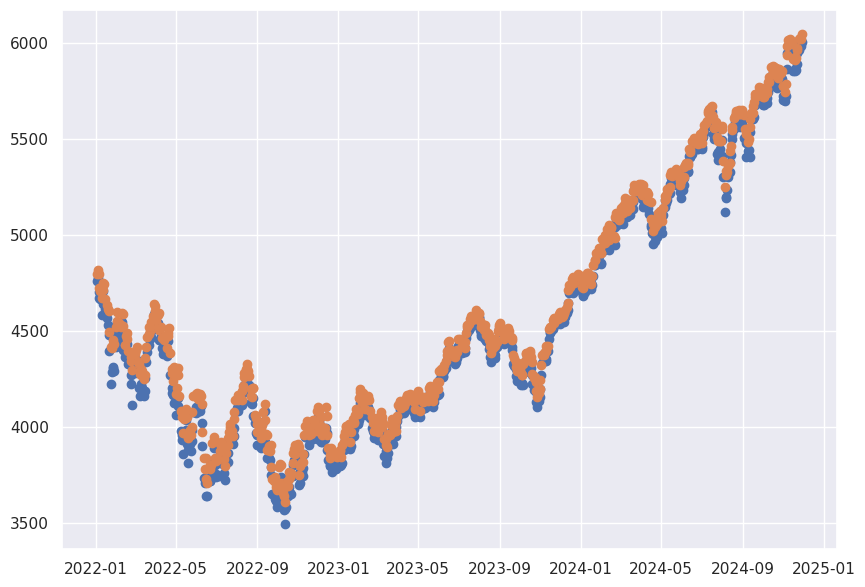

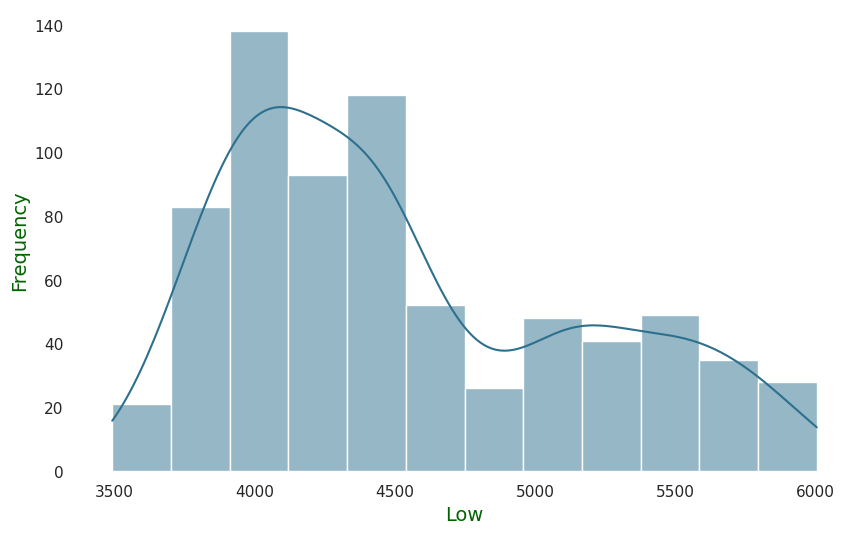

In [12]:
#scater plot
plt.figure(figsize=(10, 7))
plt.scatter(y= smp500.low, x =smp500.index.to_timestamp())
plt.scatter(y= smp500.high, x =smp500.index.to_timestamp())

# histogram
sns.set(style="white")
colors = sns.color_palette("viridis", n_colors=10)

# plotting the SAT score distribution using Seaborn with a KDE (Kernel Density Estimate) plot
plt.figure(figsize=(10, 6))
# sns.histplot(smp500.open, kde=True, color=colors[0])
# sns.histplot(smp500.close, kde=True, color=colors[1])
# sns.histplot(smp500.high, kde=True, color=colors[2])
sns.histplot(smp500.low, kde=True, color=colors[3])
# sns.histplot(smp500.volume, kde=True, color=colors[3])

# Remove left and bottom spines to eliminate the box
sns.despine(left=True, bottom=True)

# set the title and labels
# plt.title("SAT Score Distribution", fontsize=18, color='darkgreen')
plt.xlabel("Low", fontsize=14, color='darkgreen')
plt.ylabel("Frequency", fontsize=14, color='darkgreen')


# display the plot
plt.show()

# Q2

In [14]:
firstPredictionRange = smp500[(smp500.index >= '2022-02-01')&(smp500.index < '2023-01-01')]
first_year = smp500.drop(columns = ['volume'])[(smp500.index >= '2022-01')&(smp500.index < '2023-01')]
firstEleven = first_year[(first_year.index >= '2022-02')].sort_index()
firstPredictionLength = len(firstPredictionRange)
future_dates = pd.date_range(start='2022-02-01', periods=firstPredictionLength, freq='B')  # Business days
# data = smp500.drop(columns = 'volume')[smp500.index >= '2022-02']

In [15]:
def calculateMSE(prediction, realData, axis= 0):
    return ((realData - prediction)**2).sum(axis=axis)/len(realData)

In [16]:
def calculateMAD(prediction, realData, axis= 0):
    return np.abs((realData - prediction)).sum(axis=axis)/len(realData)

### Naive Aproach

In [18]:
# group by month
monthly_summary = smp500.drop(columns = ['volume'])
naivePrediction = first_year[(first_year.index == '2022-01-31')].iloc[0]
firstMonth = first_year[(first_year.index >= '2022-01') & (first_year.index < '2022-02')]

# repeat the row to match the size of the test data
repeated_naiveResult = pd.DataFrame([naivePrediction] * len(firstEleven), columns=firstEleven.columns, index=firstEleven.index)

print(calculateMSE(repeated_naiveResult, firstEleven), end="\n\n")
print(calculateMAD(repeated_naiveResult, firstEleven))

open     208337.509295
high     247772.777706
low      223657.599147
close    278875.875106
dtype: float64

open     394.265498
high     432.201991
low      410.237532
close    463.375671
dtype: float64


### Rolling window

In [20]:
# first_year.sort_index(ascending = True, inplace=True)


In [21]:
#We compute a fast moving average of 5 days (MA40) and a slow moving average of 20 days on the close price.
data = firstMonth.copy()

MAS = 5
MAF = 20 #20 should be the maximum because we have 20 days with data
data['rolling_low_mean'] = data['low'].rolling(window=MAS).mean()
data['rolling_low_mean_fast'] = data['low'].rolling(window=MAF).mean()

predicted_values = []
last_window = data['low'].iloc[-MAS:].tolist()
predicted_values_fast = []
last_window_fast = data['low'].iloc[-MAF:].tolist()

for _ in range(firstPredictionLength):
    # Calculate the mean of the current window
    next_prediction = sum(last_window) / MAS
    predicted_values.append(next_prediction)
    last_window.pop(0)
    last_window.append(next_prediction)
    next_prediction_fast = sum(last_window_fast) / MAF
    predicted_values_fast.append(next_prediction_fast)
    
    last_window_fast.pop(0)
    last_window_fast.append(next_prediction_fast)

# Create a DataFrame for predictions
predictions = pd.DataFrame({'date': future_dates.to_period('D'), 'low': predicted_values}).set_index('date')
predictions_fast = pd.DataFrame({'date': future_dates.to_period('D'), 'low': predicted_values_fast}).set_index('date')

# Display predictions
# print(predictions)
# print(predictions_fast)

print(calculateMSE(predictions['low'], firstEleven['low']), end="\n")
print(calculateMAD(predictions_fast['low'], firstEleven['low']))


549708.1175295819
567.2287724484225


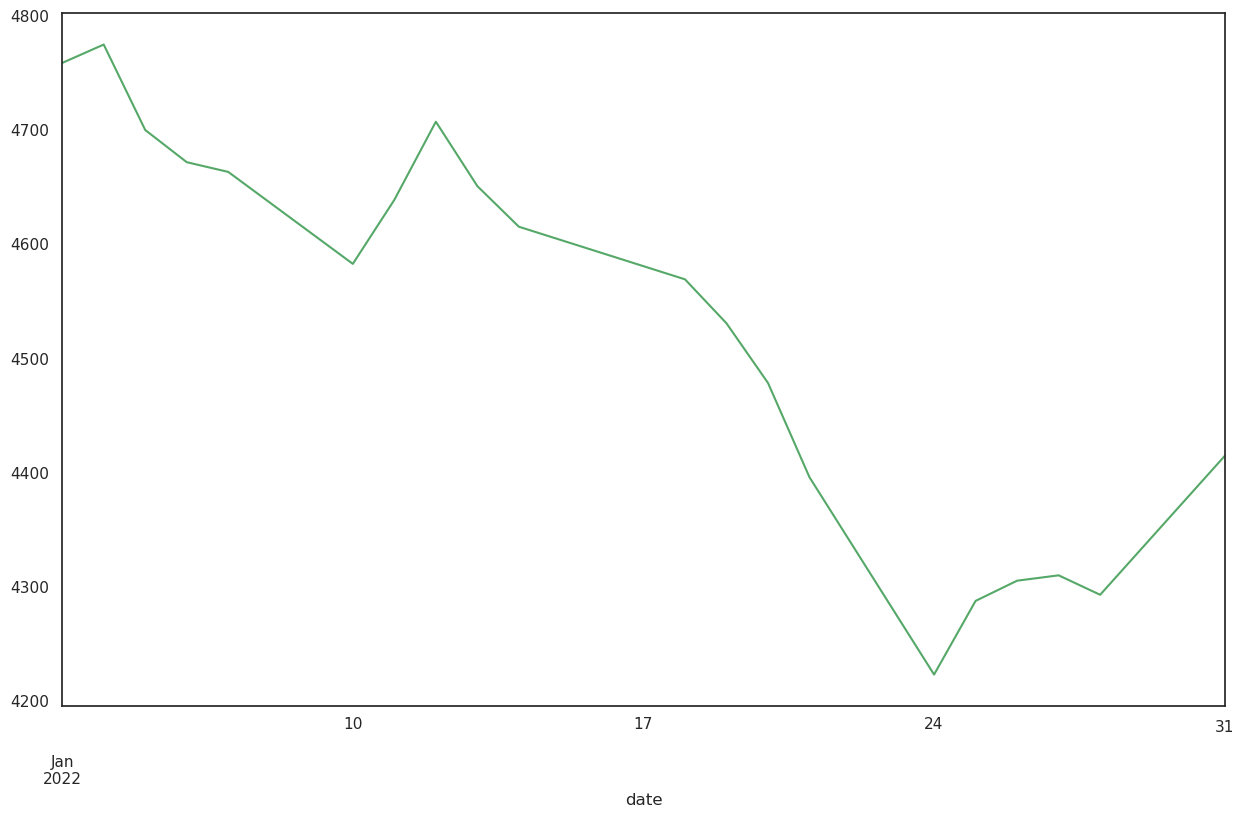

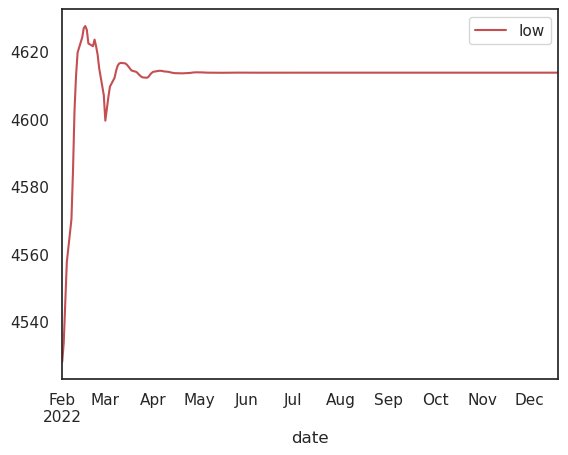

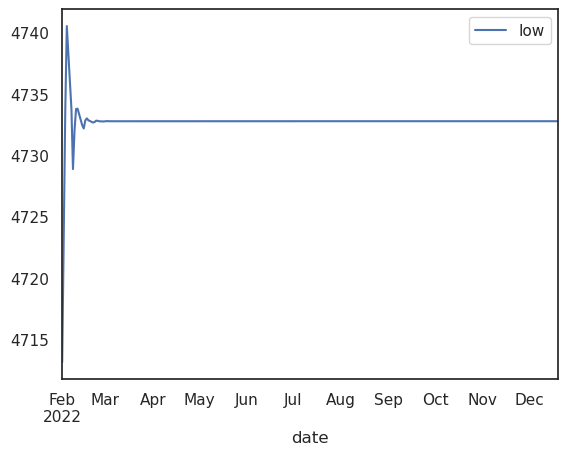

In [22]:
plt.figure(figsize= (15,9))
data['low'].plot(color = 'g', label = 'Low Price')
predictions_fast.plot(color = 'r', label = 'MA{}'.format(MAF) )
predictions.plot(color = 'b', label = 'MA{}'.format(MAS) )
plt.legend()
plt.show()

### Exponential Smoothing

### 1.0 Simple Exponential Smoothing

In [25]:
# Apply Simple Exponential Smoothing
alpha = 0.15
ses_model = SimpleExpSmoothing(data['low']).fit(smoothing_level=alpha, optimized=False)
# Forecast for the next 10 periods
forecast = ses_model.forecast(firstPredictionLength)
predictionsSES = pd.DataFrame({'date': future_dates.to_period('D'), 'low': forecast}).set_index('date')

print(calculateMSE(predictionsSES['low'], firstEleven['low']))
print(calculateMAD(predictionsSES['low'], firstEleven['low']))

432349.44712647295
594.9915948408634


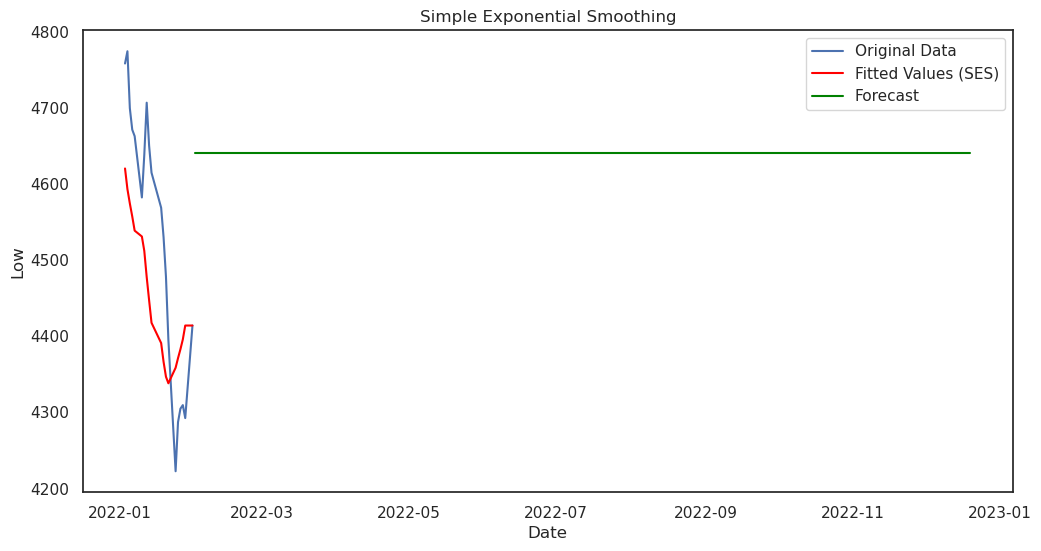

In [26]:
# Plot the original data and the forecast

plt.figure(figsize=(12, 6))
plt.plot(data.index.to_timestamp(), data['low'], label='Original Data')
plt.plot(ses_model.fittedvalues, label='Fitted Values (SES)', color='red')
plt.plot(predictionsSES, label='Forecast', color='green')
plt.title('Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.show()

### Double Exponential Smoothing

13562082.256321086
3236.789972228895


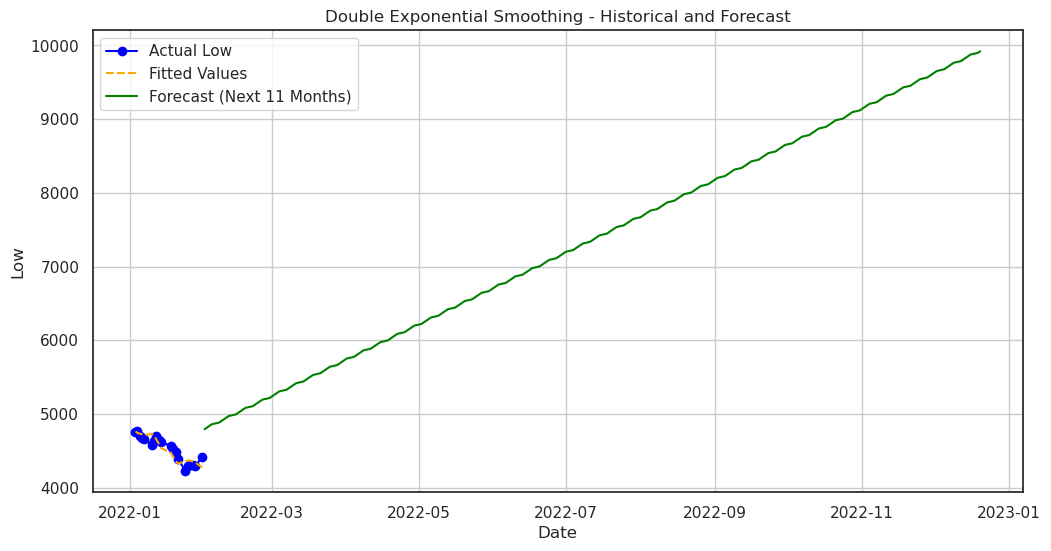

In [29]:
# Fit Double Exponential Smoothing Model
model = sm.tsa.ExponentialSmoothing(data['low'], trend='add')
des_model = model.fit(smoothing_level=0.3, smoothing_slope=0.2)

# Forecast the next 11 months
future_index = pd.date_range(start=data.index[0].to_timestamp() + pd.Timedelta(days=1), periods=firstPredictionLength, freq='B').to_period('D')

# Ensure forecast has the same length as future_index
forecast = des_model.forecast(firstPredictionLength)
forecast_df = pd.DataFrame({'low': forecast.values}, index=future_index)

print(calculateMSE(forecast_df['low'], firstEleven['low']))
print(calculateMAD(forecast_df['low'], firstEleven['low']))

# Plot Historical and Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(data.index.to_timestamp(), data['low'], label='Actual Low', marker='o', color='blue')
plt.plot(des_model.fittedvalues.index, des_model.fittedvalues, label='Fitted Values', color='orange', linestyle='--')
plt.plot(forecast_df.index, forecast_df['low'], label='Forecast (Next 11 Months)', color='green')
plt.xlabel('Date')
plt.ylabel('Low')
plt.title('Double Exponential Smoothing - Historical and Forecast')
plt.legend()
plt.grid()
plt.show()

### Holt's Linear Trend Model

In [31]:
# Apply Holt's Linear Trend Model
# Source: https://www.statology.org/how-to-apply-exponential-smoothing-to-time-series-data-in-python/
holt_model = ExponentialSmoothing(data['low'], trend='add').fit()

# Forecast for the next 10 periods
forecast_holt = holt_model.forecast(firstPredictionLength)
lieanrHoltsDf = pd.DataFrame({'low': forecast_holt.values}, index=future_index)

print(calculateMSE(lieanrHoltsDf['low'], firstEleven['low']))
print(calculateMAD(lieanrHoltsDf['low'], firstEleven['low']))

8632420.108593706
2596.0129173267865


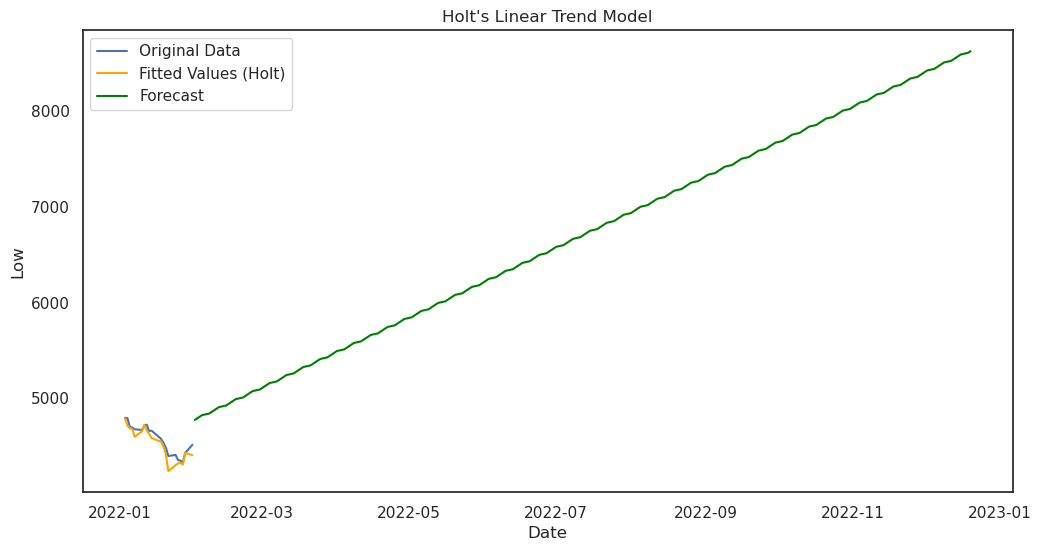

In [32]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index.to_timestamp(), data['close'], label='Original Data')
plt.plot(holt_model.fittedvalues, label='Fitted Values (Holt)', color='orange')
plt.plot(lieanrHoltsDf, label='Forecast', color='green')
plt.title("Holt's Linear Trend Model")
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.show()

### Holt Winter’s Exponential Smoothing (HWES)

In [34]:
data = data.copy()
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

def plot_func(forecast1: List[float],
              forecast2: List[float],
              forecast3: List[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['low'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['low'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test.index, y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Low Volume')
    return fig.show()

In [35]:
train = train.sort_index()
model_simple = SimpleExpSmoothing(train['low']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

In [36]:
# Fit Holt's model
model_holt = Holt(train['low'], damped_trend=True, initialization_method='estimated').fit(optimized=True)
forecasts_holt = model_holt.forecast(firstPredictionLength)

In [37]:
# Fit Holt-Winters model
model_holt_winters = ExponentialSmoothing(
    train['low'], trend='mul', seasonal='mul', seasonal_periods=7, initialization_method='estimated'
).fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(firstPredictionLength)

forecast_index = pd.date_range(start=train.index[-1].to_timestamp() + pd.Timedelta(days=1), periods=firstPredictionLength, freq='D').to_period('D')
forecast_df = pd.DataFrame({
    'Holt Forecast': forecasts_holt.values,
    'Holt-Winters Forecast': forecasts_holt_winters.values
}, index=forecast_index)

In [68]:
print(model_holt_winters.summary())

print("Holt Forecast: ")
print(calculateMSE(forecast_df['Holt Forecast'], firstEleven['low']))
print(calculateMAD(forecast_df['Holt Forecast'], firstEleven['low']))

print("Holt-Winters Forecast:")
print(calculateMSE(forecast_df['Holt-Winters Forecast'], firstEleven['low']))
print(calculateMAD(forecast_df['Holt-Winters Forecast'], firstEleven['low']))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      low   No. Observations:                   16
Model:             ExponentialSmoothing   SSE                          75389.924
Optimized:                         True   AIC                            157.325
Trend:                   Multiplicative   BIC                            165.824
Seasonal:                Multiplicative   AICC                           339.325
Seasonal Periods:                     7   Date:                 Sun, 08 Dec 2024
Box-Cox:                          False   Time:                         16:55:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9950060                alpha                 True
smoothing_trend          

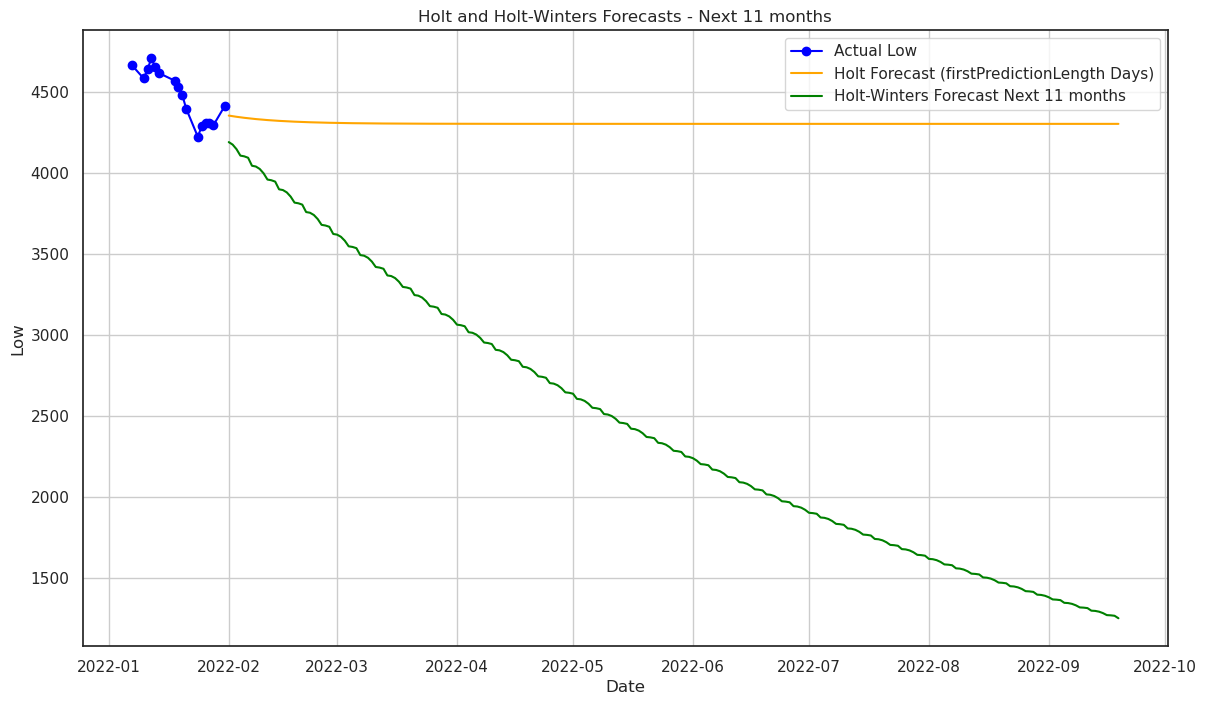

In [39]:
plt.figure(figsize=(14, 8))
plt.plot(train.index.to_timestamp(), train['low'], label='Actual Low', color='blue', marker='o')
plt.plot(forecast_df.index.to_timestamp(), forecast_df['Holt Forecast'], label='Holt Forecast (firstPredictionLength Days)', color='orange')
plt.plot(forecast_df.index.to_timestamp(), forecast_df['Holt-Winters Forecast'], label='Holt-Winters Forecast Next 11 months', color='green')

plt.title('Holt and Holt-Winters Forecasts - Next 11 months')
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.grid()
plt.show()